In [7]:
import pandas as pd
import numpy as np
from google.colab import drive

# --- 1. Setup ---
np.random.seed(42)
try:
    drive.mount('/content/drive')
except Exception:
    pass

ORIGINAL_FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'

print("Loading original dataset...")
try:
    df = pd.read_csv(ORIGINAL_FILE_PATH)
    df = df.dropna(subset=['originalScore', 'sentiment_label'])
    print(f"✅ Loaded {len(df)} rows.")
except Exception as e:
    raise SystemExit(f"Error loading file: {e}")

# --- 2. Composite Formula (Alpha=1) ---
print("\nCalculating Composite Index...")
# Formula: Score/10 + Label
df['norm_score'] = df['originalScore'] / 10.0
df['composite_index'] = df['norm_score'] + df['sentiment_label']

# --- 3. Strategic Hard Cutoffs ---
# Strategy:
# Class 0 (Neg): Pure Negative (Score 0-4, Label 0) -> Index < 0.45
# Class 1 (Neu): Mixed (Scores 5-6 Neg OR Scores 0-6 Pos) -> 0.45 < Index < 1.65
# Class 2 (Pos): Pure Positive (Scores 7-10, Label 1) -> Index > 1.65

print("Applying Cutoffs: Neg < 0.45 | 0.45 < Neu < 1.65 | Pos > 1.65")

strategic_bins = [-0.1, 0.45, 1.65, 2.1]
class_labels = [0, 1, 2]

df['target_label'] = pd.cut(df['composite_index'], bins=strategic_bins, labels=class_labels)

print("\n✅ Part 1 Complete. Data categorized.")
print("Raw Pool Sizes (Before Balancing):")
print(df['target_label'].value_counts().sort_index())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading original dataset...
✅ Loaded 194801 rows.

Calculating Composite Index...
Applying Cutoffs: Neg < 0.45 | 0.45 < Neu < 1.65 | Pos > 1.65

✅ Part 1 Complete. Data categorized.
Raw Pool Sizes (Before Balancing):
target_label
0    55029
1    69605
2    70167
Name: count, dtype: int64


In [12]:
# ==========================================
# PART 2: BALANCING & SAVING (WITH ALL COLUMNS)
# ==========================================
print("\nStarting Balancing Process (Targeting ~55k per class)...")

# Define the ideal target (55k)
TARGET_SIZE = 55000
TARGET_HALF = int(TARGET_SIZE / 2)  # 27,500

# --- A. BUILD NEUTRAL CLASS (Class 1) ---
# We need equal Original-Neg and Original-Pos
neutral_pool = df[df['target_label'] == 1]
neu_orig_neg = neutral_pool[neutral_pool['sentiment_label'] == 0]
neu_orig_pos = neutral_pool[neutral_pool['sentiment_label'] == 1]

print(f"   > Neutral Raw Pool: {len(neu_orig_neg)} Neg-Source | {len(neu_orig_pos)} Pos-Source")

# Find max possible size for a 50/50 split
# If we have enough for 55k total (27.5k each), take that.
# If not, take the bottleneck limit.
limit_per_side = min(len(neu_orig_neg), len(neu_orig_pos), TARGET_HALF)
total_neutral = limit_per_side * 2

print(f"   > Neutral Strategy: Taking {limit_per_side} from each side.")
print(f"   > Final Neutral Size: {total_neutral}")

neu_final_neg = neu_orig_neg.sample(n=limit_per_side, random_state=42)
neu_final_pos = neu_orig_pos.sample(n=limit_per_side, random_state=42)
df_neutral_final = pd.concat([neu_final_neg, neu_final_pos])

# --- B. BUILD NEGATIVE (0) & POSITIVE (2) CLASSES ---
# We try to hit 55,000 for these
pool_neg = df[df['target_label'] == 0]
pool_pos = df[df['target_label'] == 2]

# Take 55k or max available
n_neg = min(len(pool_neg), TARGET_SIZE)
n_pos = min(len(pool_pos), TARGET_SIZE)

print(f"   > Negative Size: {n_neg}")
print(f"   > Positive Size: {n_pos}")

df_neg_final = pool_neg.sample(n=n_neg, random_state=42)
df_pos_final = pool_pos.sample(n=n_pos, random_state=42)

# --- C. COMBINE & SAVE ---
df_golden = pd.concat([df_neg_final, df_neutral_final, df_pos_final])
df_golden = df_golden.sample(frac=1, random_state=42).reset_index(drop=True)

# Save Path
SAVE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/Alpha=1compositve 165k.csv'

# --- CRITICAL FIX: INCLUDE ALL METADATA COLUMNS ---
cols_to_keep = [
    'title',
    'reviewText',
    'originalScore',
    'audienceScore',
    'tomatoMeter',
    'runtimeMinutes',
    'genre',
    'sentiment_label',
    'language_encoded',
    'director_encoded',
    'target_label'
]

# Safety check: only keep columns that actually exist in your dataframe
valid_cols = [c for c in cols_to_keep if c in df_golden.columns]

df_save = df_golden[valid_cols]

df_save.to_csv(SAVE_PATH, index=False)
print(f"\n✅ Part 2 Complete. Saved {len(df_save)} rows to:")
print(SAVE_PATH)
print("Columns included:", df_save.columns.tolist())


Starting Balancing Process (Targeting ~55k per class)...
   > Neutral Raw Pool: 42007 Neg-Source | 27598 Pos-Source
   > Neutral Strategy: Taking 27500 from each side.
   > Final Neutral Size: 55000
   > Negative Size: 55000
   > Positive Size: 55000

✅ Part 2 Complete. Saved 165000 rows to:
/content/drive/MyDrive/THESIS 47/Saved Datasets/Alpha=1compositve 165k.csv
Columns included: ['title', 'reviewText', 'originalScore', 'audienceScore', 'tomatoMeter', 'runtimeMinutes', 'genre', 'sentiment_label', 'language_encoded', 'director_encoded', 'target_label']



Loading saved file for verification...

FINAL INTEGRITY REPORT
               Original Neg (0)  Original Pos (1)
Class 0 (Neg)             55000                 0
Class 1 (Neu)             27500             27500
Class 2 (Pos)                 0             55000
--------------------------------------------------
✅ Class 0 (Negative) is Pure (0 Positive reviews).
✅ Class 2 (Positive) is Pure (0 Negative reviews).
✅ Class 1 (Neutral) Balance: 27500 vs 27500
   (Perfect 50/50 Split)


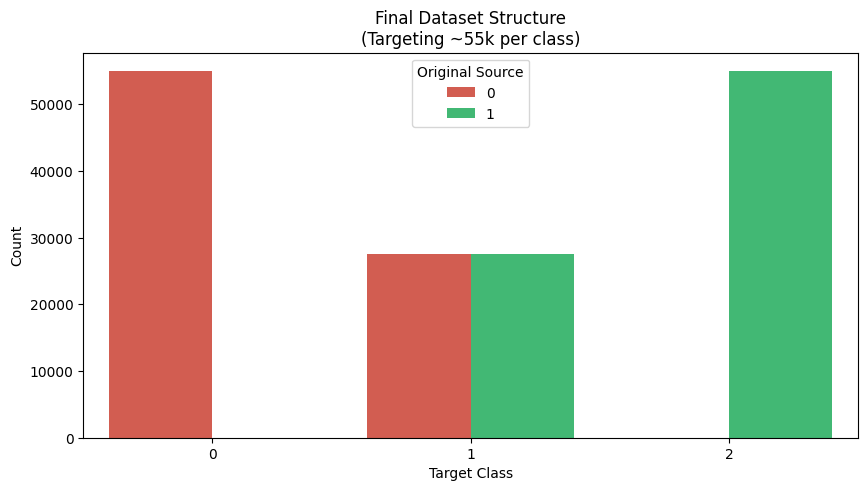

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 5. Verification ---
SAVE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/Alpha=1compositve 165k.csv'
print("\nLoading saved file for verification...")
df_check = pd.read_csv(SAVE_PATH)

print("\n" + "="*50)
print("FINAL INTEGRITY REPORT")
print("="*50)

# 1. Composition Table
integrity_table = pd.crosstab(df_check['target_label'], df_check['sentiment_label'])
integrity_table.columns = ['Original Neg (0)', 'Original Pos (1)']
integrity_table.index = ['Class 0 (Neg)', 'Class 1 (Neu)', 'Class 2 (Pos)']

print(integrity_table)
print("-" * 50)

# 2. Logic Checks
# Negative Class Purity
neg_errors = integrity_table.loc['Class 0 (Neg)', 'Original Pos (1)']
if neg_errors == 0:
    print("✅ Class 0 (Negative) is Pure (0 Positive reviews).")
else:
    print(f"❌ Class 0 contains {neg_errors} Positive reviews!")

# Positive Class Purity
pos_errors = integrity_table.loc['Class 2 (Pos)', 'Original Neg (0)']
if pos_errors == 0:
    print("✅ Class 2 (Positive) is Pure (0 Negative reviews).")
else:
    print(f"❌ Class 2 contains {pos_errors} Negative reviews!")

# Neutral Balance
neu_neg_count = integrity_table.loc['Class 1 (Neu)', 'Original Neg (0)']
neu_pos_count = integrity_table.loc['Class 1 (Neu)', 'Original Pos (1)']
print(f"✅ Class 1 (Neutral) Balance: {neu_neg_count} vs {neu_pos_count}")
if neu_neg_count == neu_pos_count:
    print("   (Perfect 50/50 Split)")

# 3. Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=df_check, x='target_label', hue='sentiment_label', palette={0: '#e74c3c', 1: '#2ecc71'})
plt.title('Final Dataset Structure\n(Targeting ~55k per class)')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.legend(title='Original Source')
plt.show()


Generating Distribution Graphs...


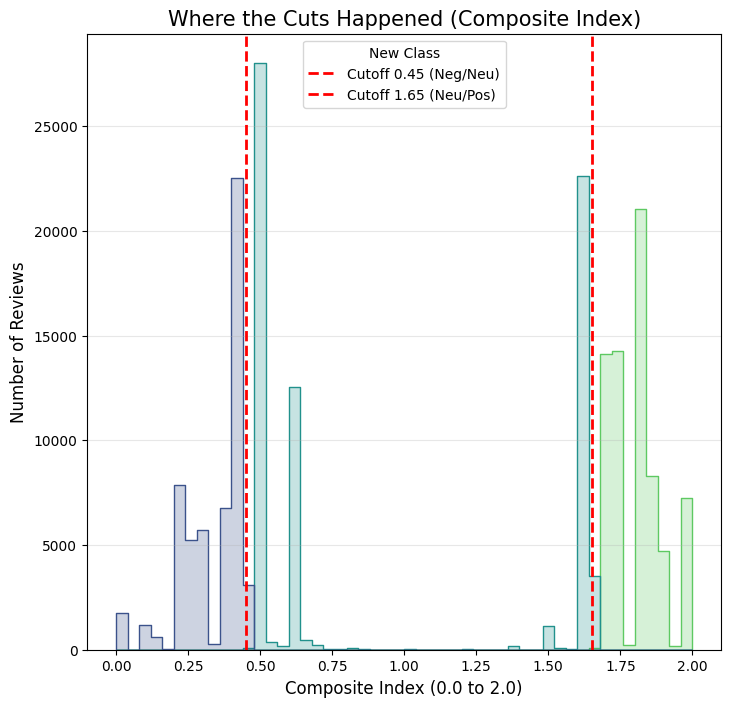

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# PART 4: VISUALIZATION (Cutoffs & Score Dist)
# ==========================================
print("\nGenerating Distribution Graphs...")

plt.figure(figsize=(18, 8))

# --- GRAPH 1: The Composite Index & Cutoffs ---
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='composite_index', hue='target_label', bins=50, palette='viridis', element='step')

# Add the Cutoff Lines
plt.axvline(x=0.45, color='red', linestyle='--', linewidth=2, label='Cutoff 0.45 (Neg/Neu)')
plt.axvline(x=1.65, color='red', linestyle='--', linewidth=2, label='Cutoff 1.65 (Neu/Pos)')

plt.title('Where the Cuts Happened (Composite Index)', fontsize=15)
plt.xlabel('Composite Index (0.0 to 2.0)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='New Class')
plt.grid(axis='y', alpha=0.3)



PART 2: CLEANING & SAVING FULL DATASET (Method 1)
Applying Strict Purity Filters...
   > Removed 0 contaminated rows from Negative Class.
   > Removed 0 contaminated rows from Positive Class.

✅ SUCCESS! Saved 194801 rows to:
/content/drive/MyDrive/THESIS 47/Saved Datasets/Composite1_194kdata.csv

FINAL SANITY CHECK REPORT
1. Class Composition (Check for Purity):
                Orig Neg (0)  Orig Pos (1)
Negative Class         55029             0
Neutral Class          42007         27598
Positive Class             0         70167
------------------------------------------------------------
✅ PASS: Negative Class is 100% Pure.
✅ PASS: Positive Class is 100% Pure.


/tmp/ipython-input-1143327202.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_save, x='target_label', palette='viridis')
/tmp/ipython-input-1143327202.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Original Source')


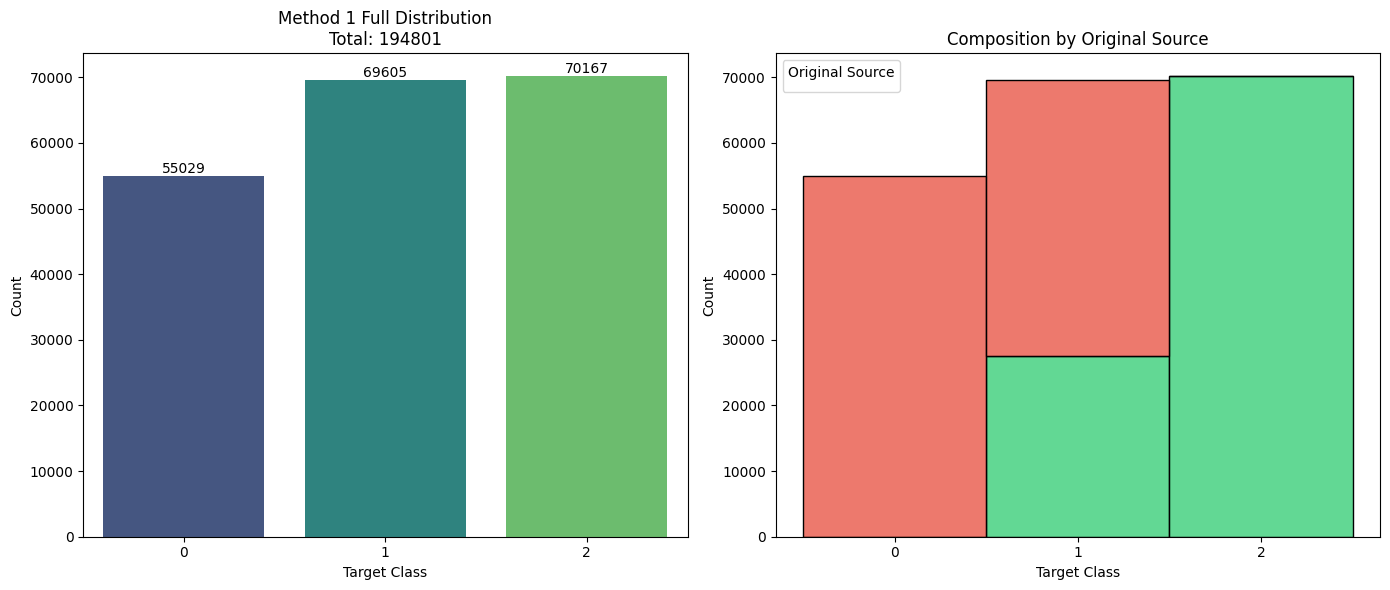

In [15]:
# ==========================================
# PART 2: CLEANING, SAVING FULL DATA & EDA
# ==========================================
print("\n" + "="*60)
print("PART 2: CLEANING & SAVING FULL DATASET (Method 1)")
print("="*60)

SAVE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/Composite1_194kdata.csv'

# --- 1. PURITY FILTERING (Removing Contamination) ---
print("Applying Strict Purity Filters...")

# Negative Class (0): Must strictly be Original Negative (0)
# (Removes the ~3 outliers you saw earlier)
df_neg_clean = df[(df['target_label'] == 0) & (df['sentiment_label'] == 0)]

# Positive Class (2): Must strictly be Original Positive (1)
# (Removes the ~14 outliers you saw earlier)
df_pos_clean = df[(df['target_label'] == 2) & (df['sentiment_label'] == 1)]

# Neutral Class (1): Keep EVERYTHING (Mixed is good here)
df_neu_clean = df[df['target_label'] == 1]

# Report on cleaning
removed_neg = len(df[df['target_label'] == 0]) - len(df_neg_clean)
removed_pos = len(df[df['target_label'] == 2]) - len(df_pos_clean)
print(f"   > Removed {removed_neg} contaminated rows from Negative Class.")
print(f"   > Removed {removed_pos} contaminated rows from Positive Class.")

# --- 2. COMBINE (NO DOWNSAMPLING) ---
df_full_clean = pd.concat([df_neg_clean, df_neu_clean, df_pos_clean])
df_full_clean = df_full_clean.sample(frac=1, random_state=42).reset_index(drop=True)

# --- 3. SAVE WITH ALL COLUMNS ---
cols_to_keep = [
    'title',                # Metadata
    'reviewText',           # Feature
    'originalScore',        # Feature
    'audienceScore',        # Feature
    'tomatoMeter',          # Feature
    'runtimeMinutes',       # Metadata
    'genre',                # Metadata
    'sentiment_label',      # Original Label
    'language_encoded',     # Metadata
    'director_encoded',     # Metadata
    'target_label'          # The New Class
]

# Safety check to ensure columns exist
valid_cols = [c for c in cols_to_keep if c in df_full_clean.columns]
df_save = df_full_clean[valid_cols]

df_save.to_csv(SAVE_PATH, index=False)
print(f"\n✅ SUCCESS! Saved {len(df_save)} rows to:")
print(SAVE_PATH)

# ==========================================
# PART 3: SANITY CHECK & EDA
# ==========================================
print("\n" + "="*60)
print("FINAL SANITY CHECK REPORT")
print("="*60)

# A. Composition Matrix
print("1. Class Composition (Check for Purity):")
cross_tab = pd.crosstab(df_save['target_label'], df_save['sentiment_label'])
cross_tab.columns = ['Orig Neg (0)', 'Orig Pos (1)']
cross_tab.index = ['Negative Class', 'Neutral Class', 'Positive Class']
print(cross_tab)
print("-" * 60)

# B. Automated Verification
if cross_tab.loc['Negative Class', 'Orig Pos (1)'] == 0:
    print("✅ PASS: Negative Class is 100% Pure.")
else:
    print("❌ FAIL: Negative Class is still contaminated.")

if cross_tab.loc['Positive Class', 'Orig Neg (0)'] == 0:
    print("✅ PASS: Positive Class is 100% Pure.")
else:
    print("❌ FAIL: Positive Class is still contaminated.")

# C. Visualization
plt.figure(figsize=(14, 6))

# Graph 1: Total Counts
plt.subplot(1, 2, 1)
ax = sns.countplot(data=df_save, x='target_label', palette='viridis')
plt.title(f'Method 1 Full Distribution\nTotal: {len(df_save)}')
plt.xlabel('Target Class')
plt.ylabel('Count')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Graph 2: Stacked Source
plt.subplot(1, 2, 2)
sns.histplot(data=df_save, x='target_label', hue='sentiment_label', multiple='stack',
             bins=[-0.5, 0.5, 1.5, 2.5], palette={0: '#e74c3c', 1: '#2ecc71'}, discrete=True)
plt.title('Composition by Original Source')
plt.xlabel('Target Class')
plt.xticks([0, 1, 2])
plt.legend(title='Original Source')

plt.tight_layout()
plt.show()